# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 


In [7]:
import pandas as pd
from scapy.all import rdpcap, IP, TCP, UDP, DNS

netflix = rdpcap("../notebooks/data/netflix.pcap")

In [8]:
rows = []
for p in netflix:
    if IP in p:
        proto = "TCP" if TCP in p else ("UDP" if UDP in p else None) # get protocol from pcap
        sport = p[TCP].sport if TCP in p else (p[UDP].sport if UDP in p else None)
        dport = p[TCP].dport if TCP in p else (p[UDP].dport if UDP in p else None)
        rows.append({
            "timestamp": p.time,
            "src_ip": p[IP].src,
            "dst_ip": p[IP].dst,
            "protocol": proto,
            "src_port": sport,
            "dst_port": dport,
            "length": len(p),
            "has_dns": DNS in p
        }) # basically, we are just trying to turn the pcap into a pandas dataframe for easy data manipulation.

df = pd.DataFrame(rows)

# Display the first few rows
print(df.head())
print(f"\nTotal packets parsed: {len(df)}")

           timestamp         src_ip         dst_ip protocol  src_port  \
0  1518358200.534682  192.168.43.72  128.93.77.234      UDP   55697.0   
1  1518358200.534832  192.168.43.72  128.93.77.234      UDP   59884.0   
2  1518358200.539408  192.168.43.72  128.93.77.234      UDP   61223.0   
3  1518358200.541204  192.168.43.72  128.93.77.234      UDP   58785.0   
4  1518358200.545785  192.168.43.72  128.93.77.234      UDP   51938.0   

   dst_port  length  has_dns  
0      53.0      77     True  
1      53.0      77     True  
2      53.0      87     True  
3      53.0      87     True  
4      53.0      78     True  

Total packets parsed: 141338


### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

In [9]:
NETFLIX_SUFFIXES = ("netflix.com", "nflxvideo.net", "nflxso.net", "nflximg.net", "nflxext.com")

def is_netflix_domain(name: str) -> bool:
    name = name.lower().rstrip(".")
    return any(name.endswith(sfx) for sfx in NETFLIX_SUFFIXES)

def to_iter(x):
    """Return [] for None, leave list as-is, wrap single object in a list."""
    if x is None:
        return []
    if isinstance(x, list):
        return x
    return [x]

def b2s(x):
    if isinstance(x, (bytes, bytearray)):
        return x.decode(errors="ignore")
    return str(x)

netflix_domains = set()
netflix_ips = set()
ip_to_domain = {}


In [10]:
for p in netflix:
    if DNS not in p:
        continue
    dns = p[DNS]

    # --- Queries ---
    for q in to_iter(dns.qd):
        # q is a DNSQR
        qname = b2s(getattr(q, "qname", ""))
        qname = qname.lower().rstrip(".")
        if qname and is_netflix_domain(qname):
            netflix_domains.add(qname)

    # --- Answers ---
    for rr in to_iter(dns.an):      # rr is a DNSRR
        rrname = b2s(getattr(rr, "rrname", "")).lower().rstrip(".")
        if rrname and is_netflix_domain(rrname):
            # A (1) and AAAA (28) carry IP addresses in rdata
            if getattr(rr, "type", None) in (1, 28):
                ip = b2s(getattr(rr, "rdata", ""))
                if ip:
                    netflix_ips.add(ip)
                    ip_to_domain[ip] = rrname

In [11]:
netflix_df = pd.DataFrame()

In [12]:
# 4) Filter packets to those touching Netflix IPs; annotate matched endpoint
if not df.empty:
    df["domain_src"] = df["src_ip"].map(ip_to_domain)
    df["domain_dst"] = df["dst_ip"].map(ip_to_domain)
    is_netflix = df["src_ip"].isin(netflix_ips) | df["dst_ip"].isin(netflix_ips)
    netflix_df = df[is_netflix].copy()
    netflix_df["netflix_endpoint"] = netflix_df.apply(
        lambda r: ip_to_domain.get(r["dst_ip"], ip_to_domain.get(r["src_ip"], None)),
        axis=1
    )
else:
    netflix_df = pd.DataFrame()


In [13]:
print("Netflix-like domains (sample):", sorted(list(netflix_domains))[:10])
print("Unique Netflix IPs found:", len(netflix_ips))
print("Packets attributed to Netflix:", len(netflix_df), "/", len(df))
display_cols = ["timestamp","src_ip","src_port","dst_ip","dst_port","protocol","length","netflix_endpoint"]
print(netflix_df[display_cols].head(10))

Netflix-like domains (sample): ['assets.nflxext.com', 'codex.nflxext.com', 'customerevents.netflix.com', 'ipv4-c001-cdg001-ix.1.oca.nflxvideo.net', 'ipv4-c005-cdg001-ix.1.oca.nflxvideo.net', 'ipv4-c024-cdg001-ix.1.oca.nflxvideo.net', 'ipv4-c063-cdg001-ix.1.oca.nflxvideo.net', 'ipv4-c069-cdg001-ix.1.oca.nflxvideo.net', 'ipv4-c071-cdg001-ix.1.oca.nflxvideo.net', 'ipv4-c072-cdg001-ix.1.oca.nflxvideo.net']
Unique Netflix IPs found: 15
Packets attributed to Netflix: 138633 / 141338
             timestamp         src_ip  src_port          dst_ip  dst_port  \
107  1518358202.903273  192.168.43.72   58451.0  198.38.120.130     443.0   
109  1518358202.903319  192.168.43.72   58452.0  198.38.120.130     443.0   
110  1518358202.903415  192.168.43.72   58453.0  198.38.120.130     443.0   
112  1518358202.903625  192.168.43.72   58454.0    52.19.39.146     443.0   
113  1518358202.903688  192.168.43.72   58455.0    52.19.39.146     443.0   
114  1518358202.903769  192.168.43.72   58456.0    52.19

### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [14]:
import numpy as np
import pandas as pd

# --- assume netflix_df already exists with at least:
# timestamp (float), length (int), src_ip, dst_ip, src_port, dst_port

# 0) Sanitize dtypes (avoid Decimal anywhere)
netflix_df = netflix_df.copy()

# force numerics
netflix_df["timestamp"] = pd.to_numeric(netflix_df["timestamp"], errors="coerce").astype("float64")
netflix_df["length"]    = pd.to_numeric(netflix_df["length"],    errors="coerce").astype("int64", copy=False)

# ports may be nullable; coerce to Int64 -> string later
for col in ["src_port", "dst_port"]:
    netflix_df[col] = pd.to_numeric(netflix_df[col], errors="coerce").astype("Int64")

# 1) Relative time (float64)
netflix_df["rel_time"] = (netflix_df["timestamp"] - netflix_df["timestamp"].min()).astype("float64")

# 2) Flow id (5-tuple as string)
netflix_df["flow_id"] = (
    netflix_df["src_ip"].astype(str) + ":" + netflix_df["src_port"].astype("Int64").astype(str)
    + "→" +
    netflix_df["dst_ip"].astype(str) + ":" + netflix_df["dst_port"].astype("Int64").astype(str)
)

# 3) Sort and compute inter-arrival times per flow
g = netflix_df.sort_values(["flow_id", "timestamp"]).copy()
g["iat"] = g.groupby("flow_id", sort=False)["timestamp"].diff().fillna(0.0).astype("float64")

# 4) Aggregate stats (include timestamp features)
flow_stats = g.groupby("flow_id", as_index=False).agg(
    pkt_count    = ("length", "size"),
    byte_total   = ("length", "sum"),
    byte_mean    = ("length", "mean"),
    byte_std     = ("length", "std"),
    flow_t_min   = ("timestamp", "min"),
    flow_t_max   = ("timestamp", "max"),
    timestamp_mean = ("timestamp", "mean"),
    timestamp_std  = ("timestamp", "std"),
    iat_mean     = ("iat", "mean"),
    iat_std      = ("iat", "std"),
)

# duration as float64
flow_stats["flow_duration"] = (flow_stats["flow_t_max"] - flow_stats["flow_t_min"]).astype("float64")

# clean up / final types
flow_stats = flow_stats.drop(columns=["flow_t_min", "flow_t_max"]).fillna(0)
flow_stats["pkt_count"]  = flow_stats["pkt_count"].astype("int64")
for c in ["byte_total", "byte_mean", "byte_std", "iat_mean", "iat_std",
          "timestamp_mean", "timestamp_std", "flow_duration"]:
    flow_stats[c] = flow_stats[c].astype("float64")

print(flow_stats.head())

                                  flow_id  pkt_count  byte_total   byte_mean  \
0  192.168.43.72:58451→198.38.120.130:443         12      1064.0   88.666667   
1  192.168.43.72:58452→198.38.120.130:443         11       998.0   90.727273   
2  192.168.43.72:58453→198.38.120.130:443         12      1064.0   88.666667   
3    192.168.43.72:58454→52.19.39.146:443        208     25627.0  123.206731   
4    192.168.43.72:58455→52.19.39.146:443         27      3382.0  125.259259   

    byte_std  timestamp_mean  timestamp_std  iat_mean   iat_std  flow_duration  
0  50.281631    1.518358e+09       5.609749  1.203348  2.274922      14.440177  
1  52.201707    1.518358e+09       5.867467  1.312988  2.769943      14.442865  
2  50.281631    1.518358e+09       5.624564  1.203118  2.279974      14.437420  
3  66.604250    1.518358e+09      42.702941  0.667570  4.253614     138.854511  
4  67.614628    1.518358e+09      23.184106  2.771022  9.115557      74.817607  


In [15]:
# --- Diagnostics ---
print("timestamp dtype:", g["timestamp"].dtype)
print("unique flows:", g["flow_id"].nunique())
print("unique timestamps overall:", g["timestamp"].nunique())
print("flows with missing ports:", (g["src_port"].isna() | g["dst_port"].isna()).sum())

# Are many packets landing in the same 'flow_id' due to <NA> ports?
print(g["flow_id"].value_counts().head())

# Do flows actually have >1 timestamp?
print(g.groupby("flow_id")["timestamp"].nunique().sort_values(ascending=False).head())

# --- Safer flow id (don’t let <NA> collapse flows) ---
def port_str(s):
    return s.astype("Int64").astype("string").fillna("NA")

g["flow_id"] = (
    g["src_ip"].astype("string") + ":" + port_str(g["src_port"]) +
    "→" +
    g["dst_ip"].astype("string") + ":" + port_str(g["dst_port"])
)

# --- Better timestamp features ---
flow_agg = g.groupby("flow_id", as_index=False).agg(
    pkt_count   = ("length", "size"),
    byte_total  = ("length", "sum"),
    byte_mean   = ("length", "mean"),
    byte_std    = ("length", "std"),
    t_min       = ("timestamp", "min"),
    t_max       = ("timestamp", "max"),
)

# Flow center time & duration (more stable than raw mean of absolute times)
flow_agg["flow_center_ts"] = (flow_agg["t_min"] + flow_agg["t_max"]) / 2.0
flow_agg["flow_duration"]  = (flow_agg["t_max"] - flow_agg["t_min"]).astype("float64")

# If you still want a mean timestamp, compute on RELATIVE time
t0 = g["timestamp"].min()
rel = g.assign(ts_rel = g["timestamp"] - t0)

ts_rel_mean = rel.groupby("flow_id", as_index=False)["ts_rel"].mean().rename(
    columns={"ts_rel":"timestamp_rel_mean"}
)

flow_stats = (flow_agg
              .drop(columns=["t_min","t_max"])
              .merge(ts_rel_mean, on="flow_id", how="left")
              .fillna(0))

print(flow_stats.head())



timestamp dtype: float64
unique flows: 110
unique timestamps overall: 138496
flows with missing ports: 0
flow_id
198.38.120.166:443→192.168.43.72:58506    34899
192.168.43.72:58506→198.38.120.166:443    22359
198.38.120.166:443→192.168.43.72:58512    20855
198.38.120.166:443→192.168.43.72:58498    16618
192.168.43.72:58512→198.38.120.166:443    11487
Name: count, dtype: int64
flow_id
198.38.120.166:443→192.168.43.72:58506    34896
192.168.43.72:58506→198.38.120.166:443    22336
198.38.120.166:443→192.168.43.72:58512    20855
198.38.120.166:443→192.168.43.72:58498    16618
192.168.43.72:58512→198.38.120.166:443    11474
Name: timestamp, dtype: int64
                                  flow_id  pkt_count  byte_total   byte_mean  \
0  192.168.43.72:58451→198.38.120.130:443         12        1064   88.666667   
1  192.168.43.72:58452→198.38.120.130:443         11         998   90.727273   
2  192.168.43.72:58453→198.38.120.130:443         12        1064   88.666667   
3    192.168.43.72:5845

**Write a brief justification for the features that you have chosen.**

`flow_id`: Identifier for network flows - packets belonging to same flow might have some similar effects on inference

`pkt_count`: Total # of packets/flow. This indicates how long a session lasts. Useful feature because different session lengths might indicate different services, such as Netflix

`byte_total, byte_mean, byte_std`: data on byte transfer. Byte_mean, for example, represents mean payload size, and byte_std captures variability in packet capture.

`flow_duration` : captures time between first and last packet in flow. Indicates persistence of session - streaming sessions are longer.

`iat_mean` : Mean inter-arrival time between sessions. This reflects packet rate; high usually reflects buffer-y behavior 

`iat_std` : Std. dev of inter-arrival time between sessions. Netflix, for example, has low variance because it is probably better calibrated.

`timestamp_rel_mean/flow_center_ts`: Provides some measure of time for packet capture. Could be useful and an indicative feature, since behavior could vary across different time horizons

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [16]:
import pandas as pd
import numpy as np

# Inputs assumed: netflix_df (packet-level), flow_stats (per-flow with "flow_id")
# Required columns in netflix_df: timestamp, src_ip, dst_ip, src_port, dst_port, length

BIN_SEC = 2.0                 # wider bins help bytes accumulate
ROLL_WINDOW_SEC = 30.0
ROLL_BINS = max(1, int(round(ROLL_WINDOW_SEC / BIN_SEC)))
FALLBACK_MIN = 10 * 1024      # 10 KB lower bound for threshold

df = netflix_df.copy()

# ---- dtypes & flow_id (exactly as before) ----
df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce").astype(float)
df["length"]    = pd.to_numeric(df["length"],    errors="coerce").astype(int)
for c in ["src_port","dst_port"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")

def port_str(s):
    return s.astype("Int64").astype("string").fillna("NA")

df["flow_id"] = (
    df["src_ip"].astype("string") + ":" + port_str(df["src_port"])
    + "→" +
    df["dst_ip"].astype("string") + ":" + port_str(df["dst_port"])
)

# ---- bin time ----
t0 = df["timestamp"].min()
df["bin"] = ((df["timestamp"] - t0) // BIN_SEC).astype(int)

# ---- BYTES PER (FLOW, BIN): use ALL traffic so we don't miss bursts ----
bpb = (df.groupby(["flow_id","bin"], as_index=False)["length"]
         .sum()
         .rename(columns={"length":"bin_bytes"}))

if bpb.empty:
    # nothing to compute; create zeros and merge
    segment_features = flow_stats[["flow_id"]].drop_duplicates().copy()
    segment_features["segment_rate_mean"] = 0.0
    segment_features["segment_rate_max"]  = 0.0
    segment_features["segment_burst_fraction"] = 0.0
else:
    # ---- adaptive per-flow threshold that cannot exceed the flow's max ----
    stats = (bpb.groupby("flow_id")["bin_bytes"]
                .agg(q75=lambda s: s.quantile(0.75),
                     q90=lambda s: s.quantile(0.90),
                     vmax="max")
                .reset_index())
    # candidate threshold = max(q90, q75, FALLBACK_MIN), but clip to <= vmax
    stats["thr"] = np.maximum(stats[["q90","q75"]].max(axis=1), FALLBACK_MIN)
    stats["thr"] = np.minimum(stats["thr"], stats["vmax"]).astype(float)

    bpb = bpb.merge(stats[["flow_id","thr","vmax"]], on="flow_id", how="left")

    # A bin is a "segment" if it reaches the threshold and is at least 20% of that flow's max
    # (the 20% guard helps tiny flows with small maxima)
    bpb["is_segment"] = ((bpb["bin_bytes"] >= bpb["thr"]) |
                         (bpb["bin_bytes"] >= 0.20 * bpb["vmax"])).astype(int)

    # ---- rolling segment rate per flow ----
    def _rate(gr):
        gr = gr.sort_values("bin").copy()
        gr["segment_rate"] = gr["is_segment"].rolling(ROLL_BINS, min_periods=1).sum() / ROLL_WINDOW_SEC
        return gr

    rate_ts = bpb.groupby("flow_id", group_keys=False).apply(_rate)

    segment_features = (rate_ts.groupby("flow_id", as_index=False)
        .agg(segment_rate_mean=("segment_rate","mean"),
             segment_rate_max =("segment_rate","max"),
             segment_burst_fraction=("is_segment","mean"))
    )

# ---- merge & fill ----
needed = ["segment_rate_mean","segment_rate_max","segment_burst_fraction"]
for c in needed:
    if c not in segment_features.columns:
        segment_features[c] = 0.0

flow_stats = flow_stats.merge(segment_features[["flow_id"]+needed], on="flow_id", how="left")
flow_stats[needed] = flow_stats[needed].fillna(0.0)

# ---- quick diagnostics (helps if you still see zeros) ----
try:
    total_bins = len(bpb)
    total_segments = int(bpb["is_segment"].sum()) if "is_segment" in bpb else 0
    flows_with_segments = (segment_features["segment_burst_fraction"] > 0).sum()
    print(f"[diag] bins={total_bins}, segments_flagged={total_segments}, flows_with_segments={flows_with_segments}")
    print(segment_features.head())
except Exception:
    pass

print(flow_stats[["flow_id","segment_rate_mean","segment_rate_max","segment_burst_fraction"]].head())


[diag] bins=1401, segments_flagged=624, flows_with_segments=110
                                  flow_id  segment_rate_mean  \
0  192.168.43.72:58451→198.38.120.130:443           0.058333   
1  192.168.43.72:58452→198.38.120.130:443           0.086667   
2  192.168.43.72:58453→198.38.120.130:443           0.058333   
3    192.168.43.72:58454→52.19.39.146:443           0.153333   
4    192.168.43.72:58455→52.19.39.146:443           0.118519   

   segment_rate_max  segment_burst_fraction  
0          0.066667                0.500000  
1          0.133333                0.800000  
2          0.066667                0.500000  
3          0.266667                0.360000  
4          0.166667                0.555556  
                                  flow_id  segment_rate_mean  \
0  192.168.43.72:58451→198.38.120.130:443           0.058333   
1  192.168.43.72:58452→198.38.120.130:443           0.086667   
2  192.168.43.72:58453→198.38.120.130:443           0.058333   
3    192.168.43.72:

/tmp/ipykernel_1607/62532037.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rate_ts = bpb.groupby("flow_id", group_keys=False).apply(_rate)


## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [17]:
!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS

but Gdown can't. Please check connections and permissions.
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI

but Gdown can't. Please check connections and permissions.


In [18]:
import pandas as pd

# Load the dataset
file_path = "netflix_dataset.pkl"
df = pd.read_pickle(file_path)

### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [19]:
resolutions = [240, 360, 480, 720, 1080]
netflix_clean = df[df["resolution"].isin(resolutions)].copy()

print("Cleaned dataset:")
print(netflix_clean.head())

Cleaned dataset:
                                    10_EWMA_chunksizes  10_avg_chunksize  \
208  [[4380.0], [4380.0], [19682.095238095237], [23...          148947.1   
209  [[179260.0], [130204.0], [49666.09523809524], ...           91984.2   
210  [[317962.0], [83192.4], [170850.7619047619], [...          147725.0   
211  [[396800.0], [98961.6], [246910.09523809524], ...          246420.6   
212  [[325264.0], [331102.4], [365584.38095238095],...          336681.0   

     10_chunksizes_50  10_chunksizes_50R  10_chunksizes_75  10_chunksizes_75R  \
208           43473.0            43473.0          185098.0           185098.0   
209          101882.0           101882.0          122323.0           122323.0   
210          111373.0           111373.0          224157.0           224157.0   
211          297522.0           297522.0          330737.5           330737.5   
212          354461.0           354461.0          399719.5           399719.5   

     10_chunksizes_85  10_chunksizes_85

2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

In [21]:
id_like = {
    "id", "session_id", "stream_id", "trace_id", "conn_id",
    "timestamp", "time", "start_time", "end_time",
    "src_ip", "dst_ip", "src_port", "dst_port",
    "client_ip", "server_ip",
}

def is_listy(series: pd.Series) -> bool:
    """Detect if a column holds list/array/dict values."""
    if series.dtype != "object":
        return False
    for v in series.dropna().head(50):
        if isinstance(v, (list, tuple, dict, np.ndarray)):
            return True
    return False

# (a) IDs / identifiers
to_drop = set(c for c in id_like if c in netflix_clean.columns)

# (b) list/array-like columns
listy_cols = [c for c in netflix_clean.columns if is_listy(netflix_clean[c])]
to_drop.update(listy_cols)

# (c) mostly-missing
na_frac = netflix_clean.isna().mean()
mostly_missing = list(na_frac[na_frac > 0.40].index)
to_drop.update(mostly_missing)

# (d) low-variance numeric columns (skip list-like)
low_var = []
for c in netflix_clean.columns:
    if c in listy_cols:
        continue
    try:
        uniq = netflix_clean[c].nunique(dropna=True)
        if uniq <= 1:
            low_var.append(c)
        elif uniq / max(len(netflix_clean), 1) <= 0.01:
            low_var.append(c)
    except TypeError:
        # Happens for unhashable cells (e.g. arrays)
        continue
to_drop.update(low_var)

In [22]:
# (e) high-correlation numeric columns
numeric = netflix_clean.select_dtypes(include=[np.number])
if not numeric.empty:
    corr = numeric.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    collinear = [column for column in upper.columns if (upper[column] >= 0.999).any()]
    to_drop.update(collinear)
else:
    collinear = []

# ---- 3) Drop them safely ----
protect = {"resolution"}
to_drop = [c for c in sorted(to_drop) if c not in protect and c in netflix_clean.columns]

print("\nDropping columns:")
for c in to_drop:
    reasons = []
    if c in id_like: reasons.append("id")
    if c in listy_cols: reasons.append("list/array")
    if c in mostly_missing: reasons.append(">40% NaN")
    if c in low_var: reasons.append("low variance")
    if c in collinear: reasons.append("collinear")
    reason = ", ".join(reasons) if reasons else "heuristic"
    print(f" - {c}: {reason}")

netflix_clean.drop(columns=to_drop, inplace=True, errors="ignore")


Dropping columns:
 - 10_EWMA_chunksizes: list/array
 - 10_chunksizes_50R: collinear
 - 10_chunksizes_75R: collinear
 - 10_chunksizes_85R: collinear
 - 10_chunksizes_90R: collinear
 - ads: low variance
 - all_prev_down_chunk_iat_50R: collinear
 - all_prev_down_chunk_iat_75R: collinear
 - all_prev_down_chunk_iat_85R: collinear
 - all_prev_down_chunk_iat_90R: collinear
 - all_prev_down_chunk_iat_min: low variance
 - all_prev_up_chunk_iat_50R: collinear
 - all_prev_up_chunk_iat_75R: collinear
 - all_prev_up_chunk_iat_85R: collinear
 - all_prev_up_chunk_iat_90R: collinear
 - all_prev_up_chunk_iat_min: low variance
 - allprev_chunksizes_50R: collinear
 - allprev_chunksizes_75R: collinear
 - allprev_chunksizes_85R: collinear
 - allprev_chunksizes_90R: collinear
 - allprev_min_chunksize: low variance
 - avg_flow_age: collinear
 - bitrate: low variance
 - bitrate_change: low variance
 - c_bitrate_switches: low variance
 - c_rebufferings: low variance
 - c_resolution_switches: low variance
 - c

In [23]:
print(netflix_clean.shape)

(49748, 144)


**Briefly explain why you removed those columns.**

Removed the following columns for the following reasons:

IDs/timestamps: only identify sessions, not behavior.

List/array columns: not usable directly in models.

Mostly missing: contain too little data.

Low variance: nearly constant, add no information.

Highly correlated: duplicate other features.

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
y = netflix_clean["resolution"]                 # label
X = netflix_clean.drop(columns=["resolution"])  # features

# Perform train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Label distribution (train):")
print(y_train.value_counts(normalize=True))

Training set shape: (39798, 143)
Test set shape: (9950, 143)
Label distribution (train):
resolution
480.0     0.592718
720.0     0.190085
1080.0    0.093020
360.0     0.089979
240.0     0.034198
Name: proportion, dtype: float64


### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import numpy as np

# Define label and feature matrix
y = netflix_clean["resolution"]
X = netflix_clean.select_dtypes(include=[np.number]).drop(columns=["resolution"], errors="ignore").copy()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Simple logistic regression pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, multi_class="multinomial"))
])

# Hyperparameter tuning (kept small for simplicity)
param_grid = {"logreg__C": [0.1, 1, 10]}
grid = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)

# Evaluate on test data
test_acc = grid.score(X_test, y_test)
print("Test accuracy:", test_acc)


/home/srirama1/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/srirama1/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/srirama1/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/srirama1/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi

Best parameters: {'logreg__C': 10}
Best cross-validation accuracy: 0.8036333381949324
Test accuracy: 0.7979899497487437


In [ ]:
print(X_train.corrwith(y_train, method='spearman').abs().sort_values(ascending=False).head(10)) # get most correlated features

allprev_chunksizes_75    0.658460
allprev_avg_chunksize    0.653152
allprev_chunksizes_50    0.647105
allprev_chunksizes_85    0.635030
10_avg_chunksize         0.628888
10_max_chunksize         0.628834
10_chunksizes_90         0.626089
10_std_chunksize         0.624942
10_chunksizes_85         0.624456
10_chunksizes_75         0.620352
dtype: float64


### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Rebuild pipeline (after dropping 'resolution' from X)
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, multi_class="multinomial"))
])

# Define small hyperparameter grid
param_grid = {
    "logreg__C": [0.01, 0.1, 1, 10, 100],   # strength of regularization
    "logreg__solver": ["lbfgs", "saga"]     # try two solvers
}

# Perform grid search with 5-fold cross-validation
grid = GridSearchCV(
    pipe, param_grid, cv=5, scoring="accuracy", n_jobs=-1
)
grid.fit(X_train, y_train)

# Best model and performance
print("Best parameters:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)

# Evaluate on test data
test_acc = grid.score(X_test, y_test)
print("Test accuracy:", test_acc)


/home/srirama1/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/srirama1/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/srirama1/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/srirama1/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi

Best parameters: {'logreg__C': 100, 'logreg__solver': 'lbfgs'}
Best cross-validation accuracy: 0.8040353798140091
Test accuracy: 0.798391959798995


### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

Accuracy: 0.798
F1 Score (macro): 0.716


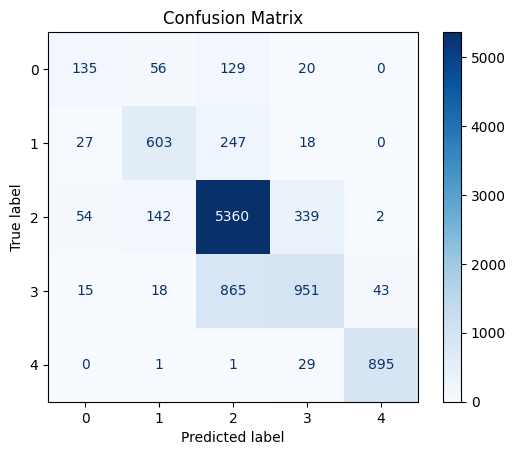

ROC-AUC (OvR): 0.938


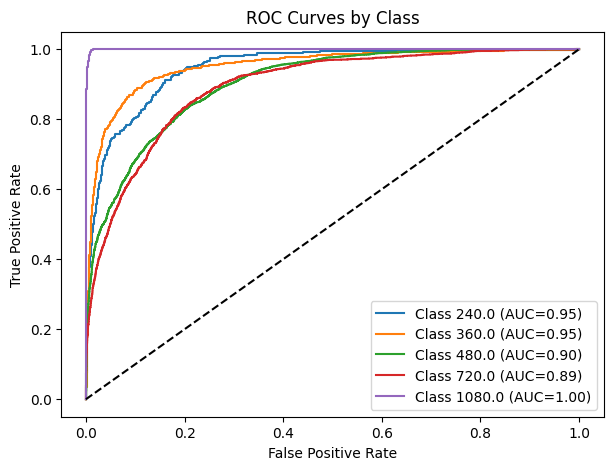

In [36]:
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, auc
)

import matplotlib.pyplot as plt
import numpy as np

# Predict on test data
y_pred = grid.predict(X_test)
y_proba = grid.predict_proba(X_test)  # probabilities needed for ROC/AUC

# 1. Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")

# 2. F1 Score (macro = equal weight for each class)
f1 = f1_score(y_test, y_pred, average="macro")
print(f"F1 Score (macro): {f1:.3f}")

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

# 4. ROC/AUC (multi-class, one-vs-rest)
try:
    auc_score = roc_auc_score(y_test, y_proba, multi_class="ovr")
    print(f"ROC-AUC (OvR): {auc_score:.3f}")

    # Optional: plot ROC for each class
    plt.figure(figsize=(7,5))
    for i, cls in enumerate(grid.best_estimator_.named_steps["logreg"].classes_):
        fpr, tpr, _ = roc_curve(y_test == cls, y_proba[:, i])
        plt.plot(fpr, tpr, label=f"Class {cls} (AUC={auc(fpr,tpr):.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves by Class")
    plt.legend()
    plt.show()
except Exception as e:
    print("ROC/AUC not computed:", e)


## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

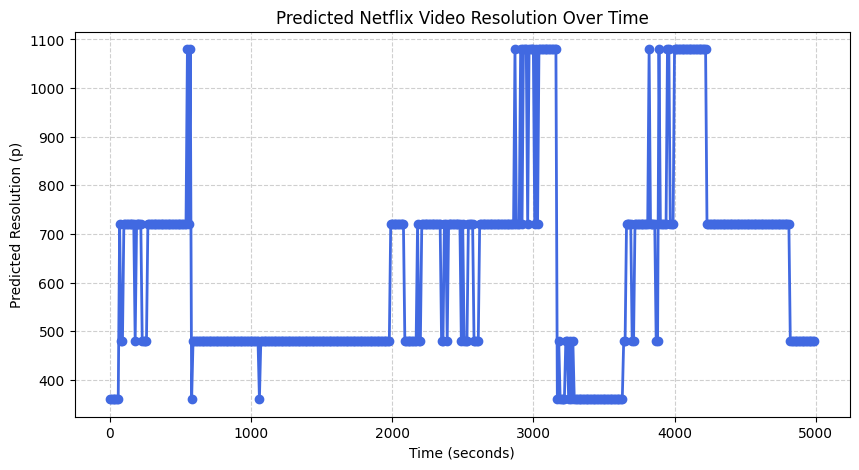

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Keep only numeric features that exist in training data
X_session = netflix_clean.select_dtypes(include=[np.number]).copy()

# Drop resolution if present (to avoid leakage)
X_session = X_session.drop(columns=["resolution"], errors="ignore")


# Predict resolution using the best trained model
y_pred_session = grid.predict(X_session)


# Simulate 10-second intervals (assuming the dataset is chronologically ordered) <-- set max to 5,000
max_time = 5000
max_points = int(max_time / 10)
time_intervals = np.arange(0, max_time, 10)
y_pred_session = y_pred_session[:max_points]

# Plot predictions over time
plt.figure(figsize=(10, 5))
plt.plot(time_intervals, y_pred_session, marker="o", linewidth=2, color="royalblue")
plt.xlabel("Time (seconds)")
plt.ylabel("Predicted Resolution (p)")
plt.title("Predicted Netflix Video Resolution Over Time")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
